# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2017

#### Número de grupo: 13
#### Integrantes:
- Giovani Rondán, CI: 4.528.997-6
- Santiago Behak, CI: 5.019.450-0

## Introducción

En el siguiente notebook se analizará la implementación de clasificadores que determinen si un tweet es humorístico o no.
Para esto se utilizaran tres enfoques diferentes, los cuales son:
- Clasificador binario basado en calificaciones previas.
- Clasificador de mediana de calificaciones previas.
- Clasificador binario basado en clasificador de mediana.

Para esto se analizará y preprocesará el corpus de entrenamiento, para luego determinar las features a utilizar para construir los clasificadores.
Se compararan los resultados de los clasificadores con un corpus de evaluación nuevo para determinar si los mismos funcionan correctamente independientemente del corpus 
El objetivo final es obtener el mejor clasificador posible en base a las pruebas realizadas.

## 1- Importación de los tweets.

Comenzaremos importando los tweets provenientes del archivo "corpus_humor_training.csv" usando la librería Pandas.
A su vez se le solicitará que indique la ruta donde se encuentra el directorio de freeling.

In [9]:
import pandas
import csv
from sklearn.cross_validation import train_test_split
import re
from pylab import *
import numpy as np
from nltk.corpus import stopwords
import IPython.display as disp
import os
import statistics
import math
from subprocess import Popen, PIPE, STDOUT
import datetime
import traceback as tb
import nltk
from nltk.metrics.scores import *
import itertools
from sklearn.metrics import classification_report
import funciones

text = input("Freeling directory ")
os.environ['FREELINGWINDOWS'] = text
corpus = pandas.read_csv("corpus_humor_training.csv",encoding='utf-8')

Freeling directory C:/grondan/PLN2/FreelingWindows


Los registros de este corpus están compuestos por varios datos además del propio texto del tweet. A continuación mostraremos la estructura del corpus y algunos de los tweets (que se encuentran en el atributo "text") a modo de ejemplo:

In [10]:
print(corpus.columns)
print ("\n")
for text in corpus['text'][:7]:
    print(text + '\n')

Index(['id', 'text', 'account_id', 'n', '1', '2', '3', '4', '5'], dtype='object')


-La semana pasada mi hijo hizo un triple salto mortal desde 20 metros de altura - ¿Es trapecista? -Era :(

-Yo ya voy por mi segundo millón de dólares... -¿!Ah, si!? -Es que el primero nunca lo hice... #fb

-Ayer fue mi cumpleaños y no me felicitaste - ¡FéÉLíCÍDáÁDÉéS! - ¿Qué haces? -Felicitarte con retraso.

No es flojera, es un estado de ahorro de energía corporal :)

- ¿Cómo te fue en matemática? -Vos sabes que soy muy pacífica - ¿Y eso qué tiene que ver? -No me gustan los problemas jajaja -Castigada - :(

"El pesimista se queja del viento; el optimista espera que cambie; el realista ajusta las velas" Feliz miércoles.

-¿Y tú desde cuando llevas pendiente? 
-Desde que mi mujer se lo encontró en el coche y le dije que era mío...



A continuación porocedemos a analizar las características del corpus obtenido, para esto obtendremos algunos datos básicos tales como la cantidad total de tweets, la cantidad de atributos de los que disponemos, la cantidad de calificaciones de los 10 tweets más calificados y la cantidad total de calificaciones.

In [11]:
cantTweets = len(corpus)
cantAtributos = len(corpus.columns)

# Imprimimos la cantidad total de tweets y la cantidad de atributos
print ("Cantidad de Tweets en el corpus: " + str(cantTweets))
print ("Cantidad de atributos en el corpus: " + str(cantAtributos))

# Imprimimos la cantidad de calificaciones de los 10 tweets mas calificados y la cantidad total de calificaciones
totalCalificaciones = 0
contador = 0
corpus["cantCalificaciones"] = [0]*len(corpus)
for i in range(0, len(corpus)):
    calificacionesTweet =corpus.loc[i, "n"] + corpus.loc[i, "1"]  + corpus.loc[i, "2"] + corpus.loc[i, "3"] + corpus.loc[i, "4"] + corpus.loc[i, "5"]
    totalCalificaciones += calificacionesTweet
    corpus.loc[i, "cantCalificaciones"] = calificacionesTweet

print ("Lista de los diez tweets con más calificaciones:\n")
disp.display(corpus.sort_values(by = ['cantCalificaciones'], ascending = False).head(10))

Cantidad de Tweets en el corpus: 12106
Cantidad de atributos en el corpus: 9
Lista de los diez tweets con más calificaciones:



,id,text,account_id,n,1,2,3,4,5,cantCalificaciones
5879,445969156437852161,"—¿A dónde vas tan maquillada? —A una fiesta, m...",1518218509,2,6,3,2,6,2,21
8158,446273545304162304,"JAJAJAJAJAJA ¿TE ACUERDAS CUANDO... ah, no, tú...",229144847,13,2,1,4,0,0,20
10238,446423336831053824,"""Tu invades mi cabeza"" —Juanita, 10 años, tien...",229144847,4,6,4,3,2,0,19
11728,464188098780618752,#Chistetipico,124053720,17,0,0,0,1,0,18
7849,447042317480763393,"""Es imposible"" dijo el orgullo; ""es arriesgado...",1518218509,6,6,1,1,3,0,17
8966,448704341365366784,-Tenemos una relación seria. -¿Lleváis mucho t...,1518218509,1,2,4,3,3,4,17
1117,446934186889211905,"Hablo 3 idiomas: español, sarcasmos e indirectas.",1518218509,6,4,1,4,0,1,16
7037,445481775133777921,Molestar a alguien solo porque te gusta ver co...,1518218509,14,1,0,1,0,0,16
9273,445669834211069952,A mi también me castigaron por reírme mientras...,1518218509,11,3,0,0,2,0,16
4306,447613590992732160,"—En mis tiempos... —Sí, sí abuela, como digas,...",1518218509,4,1,3,4,2,1,15


Otro dato que puede resultar interesante es la cantidad de calificaciones por valor (las calificaciones no humorísiticas serán contadas con el 0).

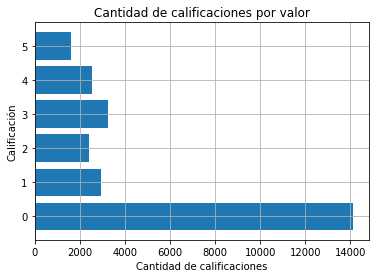

In [12]:
%matplotlib inline

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
calificacionesPorValor = [corpus["n"].sum(), corpus["1"].sum(), corpus["2"].sum(), corpus["3"].sum(), corpus["4"].sum(), corpus["5"].sum()]
valoresCalificaciones = ["0", "1", "2", "3", "4", "5"]
pos = arange(len(valoresCalificaciones)) + 0.5 

figure(1)
barh(pos,calificacionesPorValor, align='center')
yticks(pos, valoresCalificaciones)
xlabel('Cantidad de calificaciones')
ylabel(u'Calificación')
title(u'Cantidad de calificaciones por valor')
grid(True)
show()

Como se puede ver en la gráfica la mayoría de las calificaciones corresponden al valor 0, o sea, como calificaciones no humorísticas.

## 2- Preprocesmiento de los datos

En primer lugar procederemos a eleminar las columnas del corpus que consideramos innecesarias. Eliminaremos la columna de la id del tweet ya que este es un número autogenerado aleatorio que no debería aportar información relevante.

In [14]:
if "id" in corpus.columns:
    del corpus["id"]
print (corpus.columns)


Index(['text', 'account_id', 'n', '1', '2', '3', '4', '5',
       'cantCalificaciones'],
      dtype='object')


In [15]:
corpus_filtrado = funciones.preprocesar_corpus(corpus)

,text,account_id,n,1,2,3,4,5,humoristico,cantCalificaciones,mediana
0,-La semana pasada mi hijo hizo un triple salto...,118161896,0,1,1,0,0,1,True,3,2.0
1,-Yo ya voy por mi segundo millón de dólares......,132679073,2,1,0,0,0,0,False,3,0.0
2,-Ayer fue mi cumpleaños y no me felicitaste - ...,118161896,0,1,1,1,0,1,True,4,3.0
3,"No es flojera, es un estado de ahorro de energ...",1518218509,1,1,1,0,0,0,True,3,1.0
4,- ¿Cómo te fue en matemática? -Vos sabes que s...,118161896,2,0,0,1,0,0,False,3,0.0
5,"-Compadre, su hija antes me daba como por las ...",132679073,1,1,0,0,1,0,True,3,1.0
6,Había una vez una tortuguita que fue a su prim...,142482558,1,2,1,0,0,0,True,4,1.0
7,"Una novia que sea tan delicada como Neymar, es...",142482558,2,0,0,0,1,0,False,3,0.0
8,¿Qué le dice el Nesquik a la leche? ¡Te voy a ...,132679073,2,1,0,0,1,0,True,4,1.0
9,Si oscar se queda me pego un tiro con un banan...,574848706,6,1,1,0,1,0,False,9,0.0


Cantidad de tweets que quedan en el corpus luego del filtrado: 3438


Una vez filtradas las columnas del corpus nos disponemos a filtrar los tweets que tienen menos de tres calificaciones dado que los mismos no cuentan con una cantidad significativa de calificaciones como para ser evaluados. Además se eliminarán los hashtags de los textos de los tweets y agregaremos una nueva columna que determina si un tweet es humorístico en función del número de calificaciones no humorísticas en relación al total de calificaciones del tweet. Si la cantidad de calificaciones humorísticas es mayor o igual a la suma del resto de calificaciones el tweet se considerará no humorístico. También calcularemos y agregaremos otra columna que contenga la mediana de las claificaciones de los tweets, donde las calificaciones no humorísticas contarán como 0.

## 3- Separación de los datos en conjunto de train y test

A continuación dividiremos el corpus restante en un conjunto de train y en otro de test. En principio usaremos un 80% de los datos para el entrenamiento y un 20% para el testeo.

In [16]:
corpus_train, corpus_test = train_test_split(corpus_filtrado, test_size=0.2)

print ("Cantidad de tweets en el conjunto de entrenamiento: " + str(len(corpus_train)))
print ("Cantidad de tweets en el conjunto de testeo: " + str(len(corpus_test)))

Cantidad de tweets en el conjunto de entrenamiento: 2750
Cantidad de tweets en el conjunto de testeo: 688


## 4- Clasificador binario con tokenizador y POS tag de Freeling

### 4-1 Tokenización del corpus usando Freeling

Una vez separados el conjunto de train y test procedemos a tokenizar los tweets provenientes del conjunto train. Para esto usaremos la librería Freeling y NLTK. Primero definiremos una función que tokeniza un corpus usando freeling y a la que se le pueden pasar filtros para eliminar palabras basados en el postag de Freeling:

### 4-2 Pruebas de clasificadores y filtros

Con esta función probaremos dos clasificadores (Naive Bayes y Máxima Entropía) y un conjunto de filtros para eliminar tokens que en principio no parecen tan interesantes. Los filtros que consideramos probar son: "F" (signos de puntuacion), "D" (determinantes), "P" (pronombres), "S" (aposiciones) y "Z" (números). Probaremos usar todas las combinaciones de clasificadores y filtros y veremos cuales dan mejores resultados. Por ahora los únicos features que usaremos para la clasificación serán la forma de las palabras, luego agregaremos más features una vez obtenida la configuración ideal. (Atención, la siguiente cell demora mucho en ejecutarse)

In [18]:
max_accuracy = 0
filtros = ["F", "D", "P", "S", "Z"]
for i in range(1, len(filtros) + 1):
    filter_combinations = itertools.combinations(filtros, i)
    for filter_combination in filter_combinations:
        corpus_pos_tagging = funciones.filtrar_corpus(corpus_train, filter_combination, True)
        classifiers = []
        classifiers += [[nltk.classify.NaiveBayesClassifier.train(corpus_pos_tagging), "Naive Bayes"]]
        classifiers += [[nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0), "Maxima Entropia"]]
        #for classifier in classifiers:
        #    classifier[0].show_most_informative_features()
        clasificacionOficial = []
        corpus_test_tokenizado = funciones.filtrar_corpus(corpus_test, filter_combination, False)
        for classifier in classifiers:
            clasificacionCLF = []
            for tweet in corpus_test_tokenizado:
                # Se obtiene la clasificacion del algoritmo para el comentario
                try:
                    clasificacion = classifier[0].classify(tweet)
                    clasificacionCLF.append(clasificacion)
                except:
                    pass

            clasificacionOficial = []
            for index, a in corpus_test.iterrows():
                clasificacionOficial.append(a["humoristico"])

            print("Resultados de " + classifier[1] + " con filtros: " + '-'.join(filter_combination))
            print(classification_report(clasificacionOficial, clasificacionCLF))
            acc = accuracy(clasificacionOficial, clasificacionCLF)
            print("Accuracy general: " + str(acc))
            if acc > max_accuracy:
                max_accuracy = acc
                best_combination = filter_combination
                
print("\n Mejor combinacion: " + '-'.join(best_combination) + "\n Mejor accuracy: " + str(max_accuracy))

Resultados de Naive Bayes con filtros: F
             precision    recall  f1-score   support

      False       0.72      0.60      0.65       312
       True       0.71      0.81      0.75       376

avg / total       0.71      0.71      0.71       688

Accuracy general: 0.7122093023255814
Resultados de Maxima Entropia con filtros: F
             precision    recall  f1-score   support

      False       0.72      0.66      0.69       312
       True       0.74      0.79      0.76       376

avg / total       0.73      0.73      0.73       688

Accuracy general: 0.7325581395348837
Resultados de Naive Bayes con filtros: D
             precision    recall  f1-score   support

      False       0.75      0.63      0.69       312
       True       0.73      0.83      0.78       376

avg / total       0.74      0.74      0.74       688

Accuracy general: 0.7383720930232558
Resultados de Maxima Entropia con filtros: D
             precision    recall  f1-score   support

      False       

Resultados de Naive Bayes con filtros: S-Z
             precision    recall  f1-score   support

      False       0.75      0.62      0.68       312
       True       0.72      0.83      0.77       376

avg / total       0.74      0.73      0.73       688

Accuracy general: 0.7340116279069767
Resultados de Maxima Entropia con filtros: S-Z
             precision    recall  f1-score   support

      False       0.72      0.73      0.72       312
       True       0.77      0.76      0.77       376

avg / total       0.75      0.75      0.75       688

Accuracy general: 0.747093023255814
Resultados de Naive Bayes con filtros: F-D-P
             precision    recall  f1-score   support

      False       0.70      0.64      0.67       312
       True       0.72      0.77      0.75       376

avg / total       0.71      0.71      0.71       688

Accuracy general: 0.7122093023255814
Resultados de Maxima Entropia con filtros: F-D-P
             precision    recall  f1-score   support

      F

Resultados de Naive Bayes con filtros: F-P-S-Z
             precision    recall  f1-score   support

      False       0.69      0.62      0.65       312
       True       0.71      0.77      0.74       376

avg / total       0.70      0.70      0.70       688

Accuracy general: 0.7020348837209303
Resultados de Maxima Entropia con filtros: F-P-S-Z
             precision    recall  f1-score   support

      False       0.70      0.65      0.67       312
       True       0.73      0.77      0.75       376

avg / total       0.71      0.72      0.71       688

Accuracy general: 0.7151162790697675
Resultados de Naive Bayes con filtros: D-P-S-Z
             precision    recall  f1-score   support

      False       0.75      0.64      0.69       312
       True       0.74      0.82      0.77       376

avg / total       0.74      0.74      0.74       688

Accuracy general: 0.7398255813953488
Resultados de Maxima Entropia con filtros: D-P-S-Z
             precision    recall  f1-score   sup

Después de varias ejecuciones con diferentes conjuntos de test comprobamos que Máxima Entropía es claramente mejor que Naive Bayes para este clasificador: en todos los casos probados Máxima Entropía obtiene entre 2 y 5 puntos más de precisión que Naive Bayes. Además se puede ver que existen variaciones significativas de precisión para los diferentes filtros (en general existe una diferencia de 8 puntos entre la mejor y la peor combinación), en particular la precisión baja de forma apreciable en las combinaciones que poseen el filtro "F" (correspondiente a los signos de puntuación). De hecho si se listan los features más significativos de Naive Bayes sin aplicar ningún filtro se puede ver que algunos signos de puntuación como el guión "-" son de los tokens que aportan más información:

In [19]:
corpus_pos_tagging = funciones.filtrar_corpus(corpus_train, [], True)
classifier = nltk.classify.NaiveBayesClassifier.train(corpus_pos_tagging)
classifier.show_most_informative_features()

Most Informative Features
                      RT = 2               False : True   =     33.5 : 1.0
                    hijo = 1                True : False  =     20.9 : 1.0
                BUEN_DIA = 1               False : True   =     14.7 : 1.0
                       - = 4                True : False  =     13.8 : 1.0
                  Doctor = 1                True : False  =     13.3 : 1.0
                       - = 5                True : False  =     12.2 : 1.0
                    otro = 1                True : False  =     11.5 : 1.0
                      RT = 1               False : True   =     11.4 : 1.0
                   Señor = 1                True : False  =     10.9 : 1.0
                   Bueno = 1                True : False  =      9.4 : 1.0


Probablemente esto se debe a que el guión se usa para simular diálogos, los cuáles son muy frecuentes en los chistes y los relatos.


### 4-3 Pruebas con nuevos features

La prueba anterior nos permite obtener entre un 72% y un 75% de precisión, así que intentaremos mejorar estos resultados agregando nuevos features como pueden ser la id del usuario, usar el lema de las palabras en lugar de su forma y el pos-tag devuelto por Freeling para los tokens. Para estas pruebas mantendremos el clasificador de Máxima Entropía además de todos los filtros menos el de los signos de puntuación porque, como ya discutimos, esta fue la combinación que dio mejores resultados en las pruebas anteriores.

In [20]:
best_accuracy = 0

for i in range(0, 8):
    aux_i = i
    bool1 = (1 == (aux_i % 2))
    aux_i = aux_i // 2
    bool2 = (1 == (aux_i % 2))
    aux_i = aux_i // 2
    bool3 = (1 == (aux_i % 2))
    corpus_pos_tagging = funciones.filtrar_corpus(corpus_train, ["P", "S", "Z", "D"], True, bool1, bool2, bool3)
    clf = nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0)
    corpus_test_tokenizado = funciones.filtrar_corpus(corpus_test, ["P", "S", "Z", "D"], False, bool1, bool2, bool3)
    clasificacionCLF = []
    clasificacionOficial = []
    for tweet in corpus_test_tokenizado:
        #Clasificamos los tweets del corpus de test
        clasificacion = clf.classify(tweet)
        clasificacionCLF.append(clasificacion)

    #Obtenemos las clasificaciones oficiales de los tweets del conjunto de test para compararlos con los del clasificador
    clasificacionOficial =[]
    for index, a in corpus_test.iterrows():
        clasificacionOficial.append(a["humoristico"])
    print("Resultados de la prueba con features: " + str(bool1) + "-" + str(bool2) + "-" + str(bool3))
    print(classification_report(clasificacionOficial, clasificacionCLF))
    acc = accuracy(clasificacionCLF, clasificacionOficial)
    print("Accuracy general: " + str(acc))
    
    if(acc > best_accuracy):
        best_accuracy = acc
        best_features = [bool1, bool2, bool3]

print("Mejor combinacion de features: " + str(best_features[0]) + "-" + str(best_features[1]) + "-" + str(best_features[2]))


Resultados de la prueba con features: False-False-False
             precision    recall  f1-score   support

      False       0.71      0.73      0.72       312
       True       0.77      0.75      0.76       376

avg / total       0.74      0.74      0.74       688

Accuracy general: 0.7412790697674418
Resultados de la prueba con features: True-False-False
             precision    recall  f1-score   support

      False       0.70      0.71      0.70       312
       True       0.75      0.74      0.75       376

avg / total       0.73      0.73      0.73       688

Accuracy general: 0.7267441860465116
Resultados de la prueba con features: False-True-False
             precision    recall  f1-score   support

      False       0.73      0.74      0.74       312
       True       0.78      0.77      0.78       376

avg / total       0.76      0.76      0.76       688

Accuracy general: 0.7587209302325582
Resultados de la prueba con features: True-True-False
             precision  

Las pruebas indican que los mejores resultados en general se obtienen cuando todas las features mencionadas (usuario, lema de la palabra, y pos-tags de Freeling) están presentes. Se debe remarcar que dependiendo de la distribución del conjunto de test, estos resultados pueden variar, pero por lo general se mantiene la configuración que utiliza todas las features como mejor opción o con resultados muy cercanos a la mejor. En general se obtiene una mejora de entre de 2 y 5 puntos con respecto a la prueba anterior y de esta forma alcanzamos entre un 74% y un 79% de precisión.

## 5- Clasificador por mediana

A continuación construiremos un nuevo clasificador que evalúe la mediana de las clasificaciones de los tweets del corpus. Para esto usaremos la columna con los valores de las medianas previamente calculada y para ahorrar tiempo mantendremos la configuración paramétrica usada en la parte anterior (tipo de clasificador, filtros y features).

In [21]:
clasificacionCLFMediana = funciones.clasificar_corpus(corpus_train, corpus_test, True)
clasificacionOficialMediana = corpus_test.loc[:, "mediana"]
print("Resultados obtenidos para la prueba: ")
acc = accuracy(clasificacionOficialMediana, clasificacionCLFMediana)
print(classification_report(clasificacionOficialMediana, clasificacionCLFMediana))
print("Accuracy general: " + str(acc))

    |   0   1   2   3   4   5   6   7   8 |
    |   .   .   .   .   .   .   .   .   . |
    |   0   0   0   0   0   0   0   0   0 |
----+-------------------------------------+
0.0 |<285>  6  13   6   2   .   .   .   . |
1.0 |  67  <5> 13   8   4   .   .   .   . |
2.0 |  60   7 <13> 25   5   1   .   .   . |
3.0 |  52  11  13 <24>  3   .   .   .   . |
4.0 |  12   6   9  18  <5>  .   .   .   . |
5.0 |   7   2   2   4   .  <.>  .   .   . |
6.0 |   .   .   .   .   .   .  <.>  .   . |
7.0 |   .   .   .   .   .   .   .  <.>  . |
8.0 |   .   .   .   .   .   .   .   .  <.>|
----+-------------------------------------+
(row = reference; col = test)

Accuracy: 0.482558139535
Resultados obtenidos para la prueba: 
             precision    recall  f1-score   support

        0.0       0.59      0.91      0.72       312
        1.0       0.14      0.05      0.07        97
        2.0       0.21      0.12      0.15       111
        3.0       0.28      0.23      0.26       103
        4.0       0.26  

Después de realizar varias pruebas podemos concluir que para este clasificador tenemos una precisión de entre un 48% y un 53%. Estos resultados son considerablemente más bajos que los del clasificador anterior pero si consideramos que este clasificador tiene seis valores posibles en vez de dos podemos decir que siguen siendo bastante buenos. Para ilustrar estos resultados podemos ver la matriz de confusión de la prueba y calcularemos el promedio y la varianza de la desviación de los mismos:

In [73]:
promedio_desviacion = 0
varianza_desviacion = 0
aux_clasificaciones = []
for index, i in corpus_test.iterrows():
    aux_clasificaciones.append(i["mediana"]) 

for j in range(0, len(aux_clasificaciones)):
    promedio_desviacion += abs(aux_clasificaciones[j] - clasificacionCLFMediana[j])
promedio_desviacion = promedio_desviacion / len(clasificacionOficialMediana)

for k in range(0, len(aux_clasificaciones)):
    varianza_desviacion += (abs(aux_clasificaciones[k] - clasificacionCLFMediana[k]) - promedio_desviacion)**2
varianza_desviacion = varianza_desviacion / len(clasificacionOficialMediana)
print("Matriz de confusion de la prueba: ")
print(nltk.ConfusionMatrix(clasificacionOficialMediana, clasificacionCLFMediana))

print("Desviacion promedio de los resultados: " + str(promedio_desviacion))
print("Varianza de la desviacion de los resultados: " + str(varianza_desviacion))


Matriz de confusion de la prueba: 
    |   0   1   2   3   4   5   6   7   8   9 |
    |   .   .   .   .   .   .   .   .   .   . |
    |   0   0   0   0   0   0   0   0   0   0 |
----+-----------------------------------------+
0.0 |<310>  6   8   5   1   1   .   .   .   . |
1.0 |  56 <13> 15  12   3   .   .   .   .   . |
2.0 |  46  14 <13> 20   5   .   .   .   .   . |
3.0 |  50   9  12 <22>  3   .   .   .   .   . |
4.0 |  24   9   7   9  <3>  .   .   .   .   . |
5.0 |   4   1   1   5   1  <.>  .   .   .   . |
6.0 |   .   .   .   .   .   .  <.>  .   .   . |
7.0 |   .   .   .   .   .   .   .  <.>  .   . |
8.0 |   .   .   .   .   .   .   .   .  <.>  . |
9.0 |   .   .   .   .   .   .   .   .   .  <.>|
----+-----------------------------------------+
(row = reference; col = test)

Desviacion promedio de los resultados: 0.9491279069767442
Varianza de la desviacion de los resultados: 1.5075864487560984


En general obtenemos un promedio en la desviación de 0,95 y una varianza de 1,5. Esto indica que si bien tenemos una precisión relativamente baja en general el error en la estimación no es muy elevado.

## 6- Clasificador binario basado en el clasificador por mediana


Una vez que tenemos el clasificador por mediana, buscamos crear un nuevo clasificador que determine si un tweet es humorístico o no basandonos en este. Para esto haremos un post-procesamiento de la clasificación arrojada por el clasificador por mediana para el conjunto de test en el que definiremos que un tweet humorístico es todo aquel que tenga una mediana mayor a 0, luego compararemos el resultado de este post-procesamiento con las clasificaciones reales del conjunto de test. Nuevamente, para este clasificador nos basaremos en la configuración paramétrica ya establecida en partes anteriores.

In [55]:
clasificacionHumoristicoMediana = []
for clasificacion in clasificacionCLFMediana:
    clasificacionHumoristicoMediana += [clasificacion >=1]
clasificacionOficial =[]
for index, a in corpus_test.iterrows():
    clasificacionOficial.append(a["humoristico"])

print("Resultados de la prueba: ")
print(classification_report(clasificacionOficial, clasificacionHumoristicoMediana))

acc = accuracy(clasificacionOficial, clasificacionHumoristicoMediana)
print("Accuracy general: " + str(acc))

Resultados de la prueba: 
             precision    recall  f1-score   support

      False       0.63      0.94      0.76       331
       True       0.89      0.50      0.64       357

avg / total       0.77      0.71      0.69       688

Accuracy general: 0.7078488372093024


Para este clasificador en general obtenemos una precisión del 70% la cuál es un tanto inferior a los resultados del primer clasificador. Esta baja en la precisión se puede deber a que este clasificador arrastra las imprecisiones del clasificador por mediana. Estas imprecisiones se deben principalmente a que si bien el promedio y la varianza del error del clasificador por mediana es relativamente acotado aún así estos son considerables. 


## 7- Evaluación de los clasificadores con el corpus de test


Ya finalizada la construccipon de los clasificadores, evaluamos los mismos con el segundo corpus, el cual cargamos a continuación:

In [23]:
corpus_test_final = pandas.read_csv("corpus_humor_testing.csv",encoding='utf-8')
for i in range(0, (len(corpus_test_final))):
    calificacionesTweet =corpus_test_final.loc[i, "n"] + corpus_test_final.loc[i, "1"]  + corpus_test_final.loc[i, "2"] + corpus_test_final.loc[i, "3"] + corpus_test_final.loc[i, "4"] + corpus_test_final.loc[i, "5"]
    corpus_test_final.loc[i, "cantCalificaciones"] = calificacionesTweet
corpus_test_filtrado = funciones.preprocesar_corpus(corpus_test_final)

,text,account_id,n,1,2,3,4,5,humoristico,cantCalificaciones,mediana
0,"Si amas a alguien, déjalo dormir.",142482558,3,0,1,0,0,0,False,4.0,0.0
1,Ese mini infarto cuando estas caminando y un p...,1518218509,9,1,1,0,0,0,False,11.0,0.0
2,Ley del vago N° 173.979.385.685.231 eres tan v...,229144847,1,0,1,1,2,1,True,6.0,4.0
3,Sacar malas calificaciones para ocultar tu int...,124053720,0,0,0,2,1,1,True,4.0,4.0
4,Quedarte mirando a esa persona y darte cuenta ...,142482558,6,0,0,0,0,0,False,6.0,0.0
5,Si no quieres respuestas sarcásticas no hagas ...,574848706,5,0,0,0,0,0,False,5.0,0.0
6,Típico: siempre te despiertas en la mejor part...,1518218509,5,0,0,0,0,0,False,5.0,0.0
7,Busco Novia Invalida (¡Mientras más coja Mejor...,174450359,1,0,0,0,2,0,True,3.0,4.0
8,"Abuelas que antes de decirte tu nombre, nombra...",1518218509,1,1,1,1,0,0,True,4.0,2.0
9, ¿Conoces la canción de la nalga?  No.  ¿Te...,229144847,0,1,0,0,1,1,True,3.0,4.0


Cantidad de tweets que quedan en el corpus luego del filtrado: 877


### 7.1- Evaluación del clasificador binario

Lo primero que vamos a hacer , es ejecutar el clasificador binario obtenido en el punto 4, para despues comparar los resultados con los obtenidos en el otro corpus.

In [29]:
clasificacionHumoristico = funciones.clasificar_corpus(corpus_filtrado, corpus_test_filtrado, False)
clasificacionOficial =[]
for index, a in corpus_test_filtrado.iterrows():
    clasificacionOficial.append(a["humoristico"])

print("Resultados de la prueba: ")
print(classification_report(clasificacionOficial, clasificacionHumoristico))

acc = accuracy(clasificacionOficial, clasificacionHumoristico)
print("Accuracy general: " + str(acc))

  |   0   1   2 |
--+-------------+
0 |<301>100   . |
1 | 114<362>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7559863169897377
Resultados de la prueba: 
             precision    recall  f1-score   support

      False       0.73      0.75      0.74       401
       True       0.78      0.76      0.77       476

avg / total       0.76      0.76      0.76       877

Accuracy general: 0.7559863169897377


Despues de analizar las distintas ejecuciones del clasificador, comprobamos que los resultados obtenidos son similares, alcanzando un 75% de precisión.


### 7.2- Evaluación del clasificador de mediana

Ahora, evaluaremos el clasificador construido en el punto 5 para predecir la clasificación media de cada tweet

In [26]:
clasificacionCLF = funciones.clasificar_corpus(corpus_filtrado, corpus_test_filtrado, True)
clasificacionOficial =[]
for index, a in corpus_test_filtrado.iterrows():
    clasificacionOficial.append(a["mediana"])

print("Resultados de la prueba: ")
print(classification_report(clasificacionOficial, clasificacionCLF))

acc = accuracy(clasificacionOficial, clasificacionCLF)
print("Accuracy general: " + str(acc))

    |   0   1   2   3   4   5   6   7   8   9 |
    |   .   .   .   .   .   .   .   .   .   . |
    |   0   0   0   0   0   0   0   0   0   0 |
----+-----------------------------------------+
0.0 |<367> 13  10   5   4   2   .   .   .   . |
1.0 |  78 <14> 14  16   3   .   .   .   .   . |
2.0 |  59   8 <17> 35   3   .   .   .   .   . |
3.0 |  64  14  25 <28>  6   2   .   .   .   . |
4.0 |  31   8  14  21  <3>  .   .   .   .   . |
5.0 |   3   1   1   6   2  <.>  .   .   .   . |
6.0 |   .   .   .   .   .   .  <.>  .   .   . |
7.0 |   .   .   .   .   .   .   .  <.>  .   . |
8.0 |   .   .   .   .   .   .   .   .  <.>  . |
9.0 |   .   .   .   .   .   .   .   .   .  <.>|
----+-----------------------------------------+
(row = reference; col = test)

Accuracy: 0.489167616876
Resultados de la prueba: 
             precision    recall  f1-score   support

        0.0       0.61      0.92      0.73       401
        1.0       0.24      0.11      0.15       125
        2.0       0.21      0.14      

Una vez más, los resultados obtenidos se asemejan a los obtenidos con el primer corpus, con una precisión cercana al 50%. Ahora mostraremos el promedio y la varianza de la desviación de los resultados: 

In [27]:
promedio_desviacion = 0
varianza_desviacion = 0
aux_clasificaciones = []
for index, i in corpus_test_filtrado.iterrows():
    aux_clasificaciones.append(i["mediana"]) 

for j in range(0, len(aux_clasificaciones)):
    promedio_desviacion += abs(aux_clasificaciones[j] - clasificacionCLF[j])
promedio_desviacion = promedio_desviacion / len(clasificacionOficial)

for k in range(0, len(aux_clasificaciones)):
    varianza_desviacion += (abs(aux_clasificaciones[k] - clasificacionCLF[k]) - promedio_desviacion)**2
varianza_desviacion = varianza_desviacion / len(clasificacionOficial)
print("Matriz de confusion de la prueba: ")
print(nltk.ConfusionMatrix(clasificacionOficial, clasificacionCLF))

print("Desviacion promedio de los resultados: " + str(promedio_desviacion))
print("Varianza de la desviacion de los resultados: " + str(varianza_desviacion))


Matriz de confusion de la prueba: 
    |   0   1   2   3   4   5 |
    |   .   .   .   .   .   . |
    |   0   0   0   0   0   0 |
----+-------------------------+
0.0 |<367> 13  10   5   4   2 |
1.0 |  78 <14> 14  16   3   . |
2.0 |  59   8 <17> 35   3   . |
3.0 |  64  14  25 <28>  6   2 |
4.0 |  31   8  14  21  <3>  . |
5.0 |   3   1   1   6   2  <.>|
----+-------------------------+
(row = reference; col = test)

Desviacion promedio de los resultados: 0.9828962371721779
Varianza de la desviacion de los resultados: 1.4603688067931302


Como se puede apreciar, los resultados vuelvena ser similares a los analizados previamente. Aunque la precisión no es particularmente alta, la desviación promedio y la varianza promedio se mantienen acotados, por lo que se deduce que en general los tweets mal calificados no tienen calificaciones muy lejanas de su calificación real.

### 7.3- Evaluación del clasificador binario en base a mediana

Para finalizar analizaremos los resultados obtenidos por el clasificador que determina si un tweet es humorístico o no en base a la predicción de la mediana:

In [28]:
clasificacionHumoristicoMediana = []
for clasificacion in clasificacionCLF:
    clasificacionHumoristicoMediana += [clasificacion >=1]
clasificacionOficial =[]
for index, a in corpus_test_filtrado.iterrows():
    clasificacionOficial.append(a["humoristico"])

print("Resultados de la prueba: ")
print(classification_report(clasificacionOficial, clasificacionHumoristicoMediana))

acc = accuracy(clasificacionOficial, clasificacionHumoristicoMediana)
print("Accuracy general: " + str(acc))

Resultados de la prueba: 
             precision    recall  f1-score   support

      False       0.61      0.92      0.73       401
       True       0.88      0.51      0.64       476

avg / total       0.75      0.69      0.68       877

Accuracy general: 0.69327251995439


Al igual que en los casos anteriores, los resultado son similares a los obtenidos con el primer corpus con una precisión cercana al 70%.

## 8- Conclusiones finales

Si bien la tares de predecir el grado de humor de un tweet no parece sencilla en primera instancia, se puede observar que los resultados obtenidos son aceptables.
Se estima que los clasificadores pueden obtener incluso mejores resultados, si el corpus con el que se trabaja contara con mas tweets y mayor cantidad de calificaciones por cada uno de ellos.
Para procesar los datos se determinó que lo mejor es utilizar el lema y no la forma de las palabras, dado que el lema permite agrupar palabras con el mismo significado. Además al utilizar la funcionalidad de pos tagging de freeling se observó que existen tags o tipos de palabrasque son más útilies que otros a la hora de clasificar un tweet, y se realizaron filtros en base a estos datos.
El mejor clasificador obtenido es el clasificador binario, obteniendo 5 puntos mas de precisión que el clasificador binario construido en base a la predicción de la mediana.
Al utilizar el corpus de evaluación se obtuvieron resultados similares, lo que indica que los clasificadores funcionan independientemente del corpus a evaluar, esto último indicaría que los clasificadores no sufren de overfit.

Existen otras featueres que podrían einfluir en la determinación de si un tweet es humorístico o no con las que no contamos y que se podrían analizar, tales como la hora del día en la que fue emitido el tweet.